In [4]:
!pip install folium

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point

plt.rcParams['figure.figsize'] = (10,5)

In [5]:
permits = gpd.read_file('./dataset/building_permits_2017.csv')
council_districts = gpd.read_file('./dataset/council_districts.geojson')

In [6]:
# Create a shapely Point from lat and lng
permits['geometry'] = permits.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

# Build a GeoDataFrame: permits_geo
permits_geo = gpd.GeoDataFrame(permits, crs = council_districts.crs, geometry=permits.geometry)

# Spatial join of permits_geo and council_districts
permits_by_district = gpd.sjoin(permits_geo, council_districts, op='within')
print(permits_by_district.head(2))

# Create permit_counts
permit_counts = permits_by_district.groupby(['district']).size()
print(permit_counts)

C:\Users\indah\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


     permit_id      issued      cost        lat         lng  \
0   2017032777  2017-05-24  226201.0  36.198241  -86.742235   
68  2017053890  2017-09-05       0.0  36.185442  -86.768239   

                      geometry  index_right first_name  \
0   POINT (-86.74223 36.19824)            5      Scott   
68  POINT (-86.76824 36.18544)            5      Scott   

                        email     res_phone     bus_phone last_name  \
0   scott.davis@nashville.gov  615-554-9730  615-862-6780     Davis   
68  scott.davis@nashville.gov  615-554-9730  615-862-6780     Davis   

          position district  
0   Council Member        5  
68  Council Member        5  
district
1     146
10    119
11    239
12    163
13    139
14    261
15    322
16    303
17    786
18    287
19    969
2     399
20    799
21    569
22    291
23    206
24    458
25    435
26    179
27    105
28    119
29    154
3     215
30     79
31    134
32    225
33    355
34    218
35    192
4     139
5     452
6     455
7 

In [7]:
# Create an area column in council_districts
council_districts['area'] = council_districts.geometry.area
print(council_districts.head(2))

# Convert permit_counts to a DataFrame
permits_df = permit_counts.to_frame()
print(permits_df.head(2))

# Reset index and column names
permits_df.reset_index(inplace=True)
permits_df.columns = ['district', 'bldg_permits']
print(permits_df.head(2))

# Merge council_districts and permits_df
districts_and_permits = pd.merge(council_districts, permits_df, on='district')
print(districts_and_permits.head(2))

  first_name                           email     res_phone     bus_phone  \
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780   
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   

  last_name        position district  \
0  Leonardo  Council Member        1   
1  Hastings  Council Member        2   

                                            geometry      area  
0  MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ...  0.022786  
1  MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...  0.002927  
            0
district     
1         146
10        119
  district  bldg_permits
0        1           146
1       10           119
  first_name                           email     res_phone     bus_phone  \
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780   
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   

  last_name        position district  \
0  Leonardo  Council Member        1   
1  Hastings  Co

C:\Users\indah\AppData\Local\Temp\ipykernel_12612\317198333.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  council_districts['area'] = council_districts.geometry.area


In [8]:
# Print the type of districts_and_permits
print(type(districts_and_permits))

# Create permit_density column in districts_and_permits
districts_and_permits['permit_density'] = districts_and_permits.apply(lambda row: row.bldg_permits/row.area, axis=1)

# Print the head of districts_and_permits
print(districts_and_permits.head())

<class 'geopandas.geodataframe.GeoDataFrame'>
  first_name                           email     res_phone     bus_phone  \
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780   
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   
2      Nancy    nancy.vanreece@nashville.gov  615-576-0488  615-862-6780   
3       Bill    bill.pridemore@nashville.gov  615-915-1419  615-862-6780   
4     Robert      robert.swope@nashville.gov  615-308-0577  615-862-6780   

   last_name        position district  \
0   Leonardo  Council Member        1   
1   Hastings  Council Member        2   
2   VanReece  Council Member        8   
3  Pridemore  Council Member        9   
4      Swope  Council Member        4   

                                            geometry      area  bldg_permits  \
0  MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ...  0.022786           146   
1  MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...  0.002927           399   
2  MULTIPO

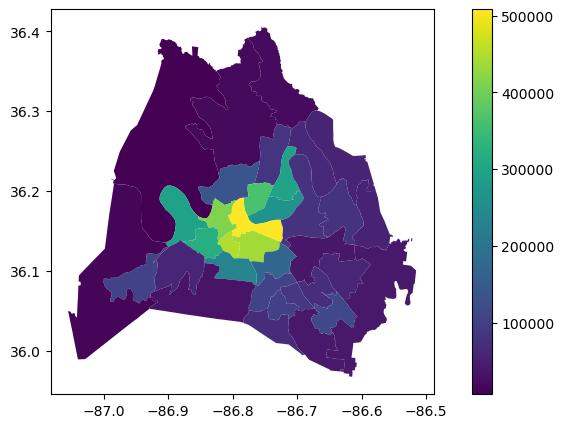

In [10]:
# Simple plot of building permit_density
districts_and_permits.plot(column='permit_density', legend=True);

Text(0.5, 1.0, '2017 Building Project Density by Council District')

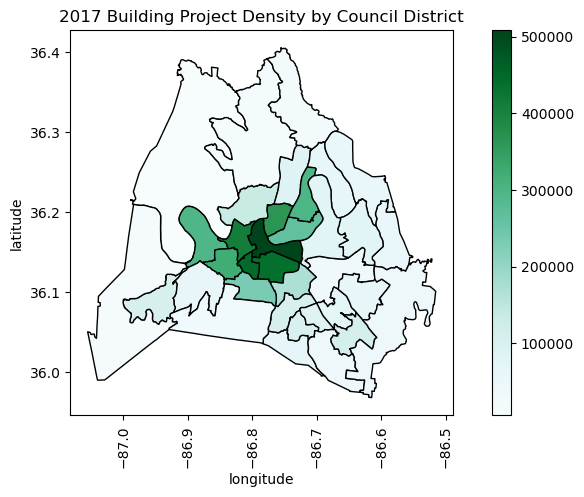

In [9]:
# Polished choropleth of building permit_density
districts_and_permits.plot(column = 'permit_density', cmap = 'BuGn', edgecolor = 'black', legend = True)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xticks(rotation = 'vertical')
plt.title('2017 Building Project Density by Council District')

In [11]:
# Change council_districts crs to epsg 3857
council_districts = council_districts.to_crs(epsg=3857)
print(council_districts.crs)
print(council_districts.head())

# Create area in square km
sqm_to_sqkm = 10 ** 6
council_districts['area'] = council_districts.geometry.area / sqm_to_sqkm

# Change council_districts crs back to epsg 4326
council_districts = council_districts.to_crs(epsg=4326)
print(council_districts.crs)
print(council_districts.head())

EPSG:3857
  first_name                           email     res_phone     bus_phone  \
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780   
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   
2      Nancy    nancy.vanreece@nashville.gov  615-576-0488  615-862-6780   
3       Bill    bill.pridemore@nashville.gov  615-915-1419  615-862-6780   
4     Robert      robert.swope@nashville.gov  615-308-0577  615-862-6780   

   last_name        position district  \
0   Leonardo  Council Member        1   
1   Hastings  Council Member        2   
2   VanReece  Council Member        8   
3  Pridemore  Council Member        9   
4      Swope  Council Member        4   

                                            geometry      area  
0  MULTIPOLYGON (((-9674485.565 4354489.556, -967...  0.022786  
1  MULTIPOLYGON (((-9657970.373 4332440.650, -965...  0.002927  
2  MULTIPOLYGON (((-9654572.680 4339671.152, -965...  0.002517  
3  MULTIPOLYGON (((-964993

In [12]:
# Create permits_geo
permits_geo = gpd.GeoDataFrame(permits, crs=council_districts.crs, geometry=permits.geometry)

# Spatially join permits_geo and council_districts
permits_by_district = gpd.sjoin(permits_geo, council_districts, op='within')

# Count permits in each district
permits_counts = permits_by_district.groupby(['district']).size()

# Convert permit_counts to a df with 2 columns: district and bldg_permits
counts_df = permits_counts.to_frame()
counts_df.reset_index(inplace=True)
counts_df.columns = ['district', 'bldg_permits']
print(counts_df.head(2))

  district  bldg_permits
0        1           146
1       10           119


C:\Users\indah\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


    permit_id      issued      cost        lat         lng  \
0  2017032777  2017-05-24  226201.0  36.198241  -86.742235   
1  2017053890  2017-09-05       0.0  36.185442  -86.768239   

                     geometry  index_right first_name  \
0  POINT (-86.74223 36.19824)            5      Scott   
1  POINT (-86.76824 36.18544)            5      Scott   

                       email     res_phone     bus_phone last_name  \
0  scott.davis@nashville.gov  615-554-9730  615-862-6780     Davis   
1  scott.davis@nashville.gov  615-554-9730  615-862-6780     Davis   

         position district       area  bldg_permits  permit_density  
0  Council Member        5  19.030612           452       23.751207  
1  Council Member        5  19.030612           452       23.751207  


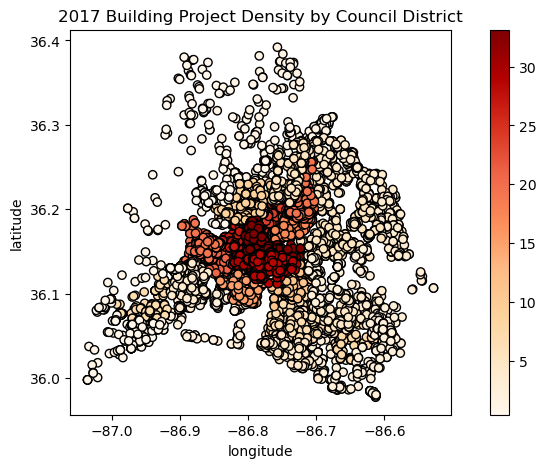

In [13]:
# Merge permits_by_district and counts_df
districts_and_permits = pd.merge(permits_by_district, counts_df, on='district')

# Create permit_density column
districts_and_permits['permit_density'] = districts_and_permits.apply(lambda row: row.bldg_permits / row.area, axis=1)
print(districts_and_permits.head(2))

# Create choropleth plot
districts_and_permits.plot(column='permit_density', cmap='OrRd', edgecolor='black', legend=True);

# Add axis labels and title
plt.xlabel('longitude');
plt.ylabel('latitude');
plt.title('2017 Building Project Density by Council District');

In [16]:
# Center point for Nashville
nashville = [36.1636,-86.7823]

# Create map
m = folium.Map(location=nashville, zoom_start=10)

# Build choropleth
folium.Choropleth(
    geo_data=r'./dataset/council_districts.geojson',
    name='geometry',
    data=districts_and_permits,
    columns=['district', 'permit_density'],
    key_on='feature.properties.district',
    fill_color='Reds',
    fill_opacity=0.5,
    line_opacity=1.0,
    legend_name='2017 Permitted Building Projects per km squared',
    
).add_to(m)

folium.LayerControl().add_to(m)

m.save('./html/permits_choropleth.html')

In [17]:
# Create center column for the centroid of each district
districts_and_permits['center'] = districts_and_permits.geometry.centroid

distinct = []
# Build markers and popups
for row in districts_and_permits.iterrows():
    row_values = row[1] 
    if row_values['district'] not in distinct:
        center_point = row_values['center']
        location = [center_point.y, center_point.x]
        popup = ('Council District: ' + str(row_values['district']) + 
             ';  ' + 'permits issued: ' + str(row_values['bldg_permits']))
        marker = folium.Marker(location = location, popup = popup)
        marker.add_to(m)
        distinct.append(row_values['district'])
    
# Display the map
m.save('./html/permits_choropleth2.html')

C:\Users\indah\AppData\Local\Temp\ipykernel_12612\3354031935.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  districts_and_permits['center'] = districts_and_permits.geometry.centroid
